In [2]:
import numpy as np
from scipy import ndimage
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from utils import u_time as ut
from eod import msg
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (16., 9.)
%matplotlib inline
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
import scipy.optimize as so
import pickle as pkl
import xarray as xr
import pandas as pd
import glob

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
def stat_per_file(file, dic):
    print('Doing', file)
    ds = xr.open_dataset(file).sel(lat=slice(10,20), lon=slice(-16,20))
    
    mask = ds['HQprecip'].values > 100
    dic['prcp'].extend(ds['HQprecip'].values[mask])
    dic['cloud'].extend(ds['tir'].values[mask])
    dic['dom'].extend(ds['dom'].values[mask])

    del ds

In [4]:
# for y in range(2005,2010):
#     dic = {'prcp' : [], 'cloud' : [], 'dom' : []}
#     #dic_miss = {'prcp' : [], 'cloud' : [], 'dom' : []}
#     core_files = glob.glob('/media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores/*'+str(y)+'-*.nc')
#     for f in core_files:
#         stat_per_file(f, dic)
        
        
#     pkl.dump(dic, open('/media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores_'+str(y)+".p", "wb"))
#     #pkl.dump(dic, open('/media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores_dmiss_'+str(y)+".p", "wb"))
#     del dic
#     #del dic_miss

Doing /media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores/GPM_Cores_2005-06.nc
Doing /media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores/GPM_Cores_2005-07.nc
Doing /media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores/GPM_Cores_2005-08.nc
Doing /media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores/GPM_Cores_2005-09.nc
Doing /media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores/GPM_Cores_2006-06.nc
Doing /media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores/GPM_Cores_2006-07.nc
Doing /media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores/GPM_Cores_2006-08.nc
Doing /media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores/GPM_Cores_2006-09.nc
Doing /media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores/GPM_Cores_2007-06.nc
Doing /media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores/GPM_Cores_2007-07.nc
Doing /media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores/GPM_Cores_2007-08.nc
Doing /media/ck/Elements/Africa/WestAfrica/MCSfiles/GP

In [14]:
dic = {'prcp' : [], 'cloud' : [], 'dom' : []}
dic_miss = {'prcp' : [], 'cloud' : [], 'dom' : []}
for y in range(2005,2010):
        ydic = pkl.load(open('/media/ck/Elements/Africa/WestAfrica/MCSfiles/GPM_on_Cores_'+str(y)+".p", "rb"))
        for k in dic.keys():
            dic[k].extend(ydic[k])       

In [138]:
np.percentile(np.array(dic['prcp'])/100,99)

37.73

In [16]:
from endgame import hist2d as hist 

ModuleNotFoundError: No module named 'endgame'

In [17]:
rp = np.arange(1,101,1)

In [18]:
import ipdb


area_tir = []
area_core = []
area_rain = []
for ids, sp in enumerate(rp[1::]):
    idx_start = rp[ids]
    idx_end = sp
    
    prcp = np.array(dic['prcp'])/100
    tir = np.array(dic['cloud'])
    core = np.array(dic['dom'])
    mask = (prcp>=idx_start) & (prcp<idx_end)
    #ipdb.set_trace()
    area_rain.append(np.sum(mask))
    area_tir.append(np.sum(mask & (tir<=-4900)))
    area_core.append(np.sum(mask & ((core>=5)| (core<-1000))))

In [19]:
xbins = rp[0:-1]+(rp[1::]-rp[0:-1])/2

In [20]:
outdic = {'pcount_cores' : np.array(area_core), 'pcount_GPM' : np.array(area_rain), 'xbins' : xbins, 'cores_frac' :  np.array(area_core)/np.array(area_rain)*100}
df = pd.DataFrame.from_dict(outdic)
df.to_csv("/home/ck/DIR/cornkle/figs/SWIFT/2w_paper/GPM_core_table_raw.csv", index=False)

In [21]:
pos = outdic['xbins']>=30
perc = np.mean(outdic['cores_frac'][pos])

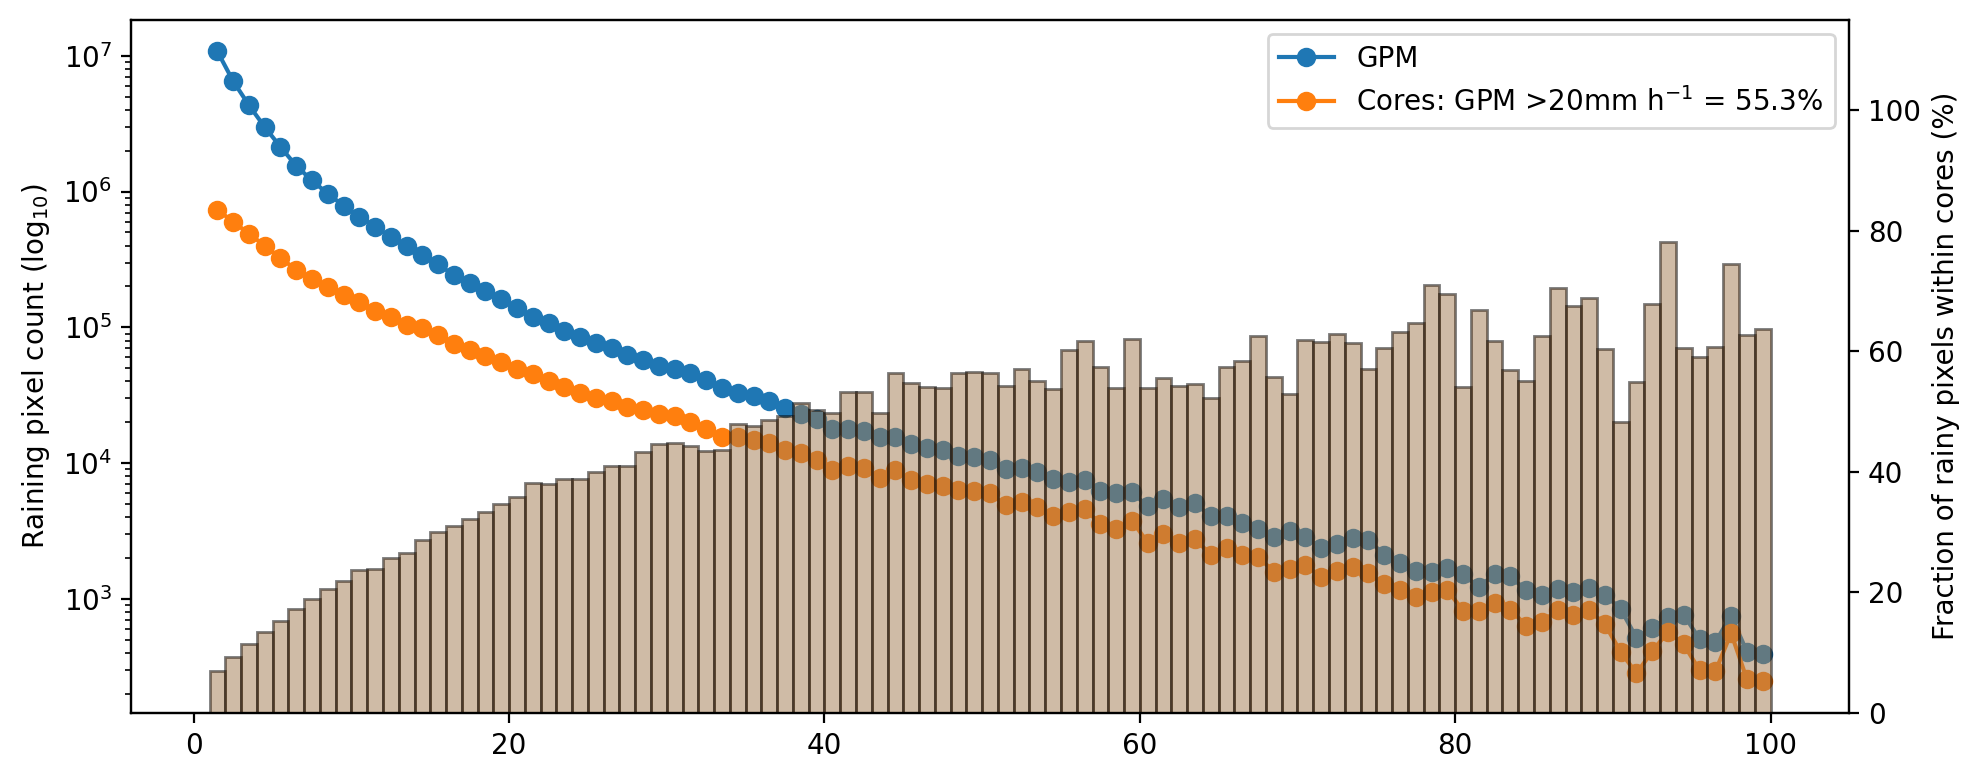

In [22]:
f = plt.figure(figsize=(10,4), dpi=200)
ax = f.add_subplot(111)
ax.set_yscale('log')
ax.plot(outdic['xbins'], outdic['pcount_GPM'], marker='o', label='GPM', zorder=99)
ax.plot(outdic['xbins'], outdic['pcount_cores'], marker='o', label='Cores: GPM >20mm h$^{-1}$ = '+str(np.round(perc,1))+'%', zorder=99)

ax2 = ax.twinx()

ax2.bar(outdic['xbins'], np.array(outdic['cores_frac']), width=1, alpha=0.3, edgecolor='k', zorder=0)
ax2.bar(outdic['xbins'], np.array(outdic['pcount_cores'])/np.array(outdic['pcount_GPM'])*100, width=1, alpha=0.3, edgecolor='k', zorder=0)
ax2.set_ylim(0,115)
ax.legend()
ax.set_ylabel('Raining pixel count (log$_{10}$)')
ax2.set_ylabel('Fraction of rainy pixels within cores (%)')
plt.tight_layout()

(0.0, 115.0)

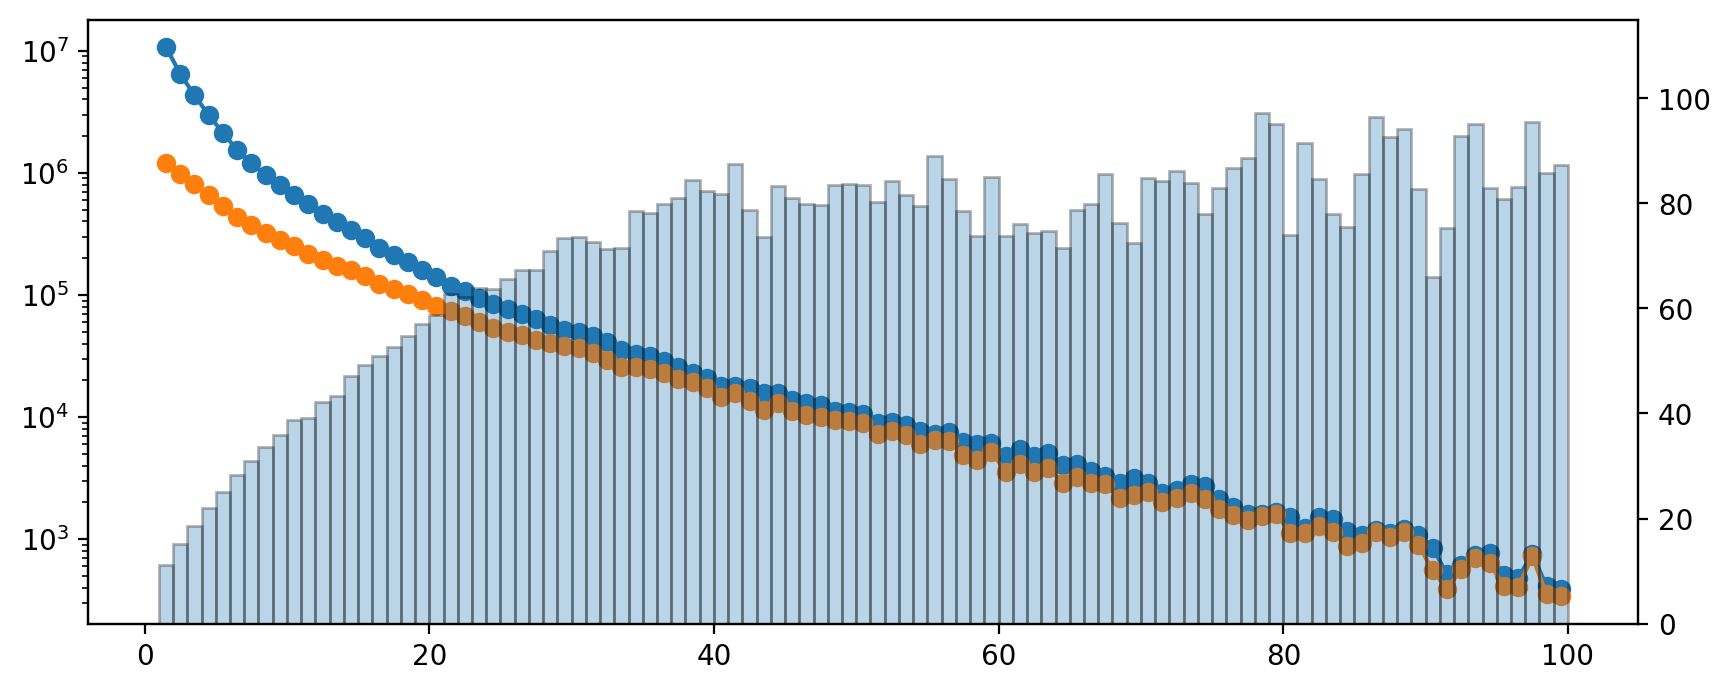

In [126]:
f = plt.figure(figsize=(10,4), dpi=200)
ax = f.add_subplot(111)
ax.set_yscale('log')
crain = np.array(area_rain).copy()
ax.plot(xbins, crain, marker='o')

ccors = np.array(area_core).copy()
ccors = ccors+0.37*ccors#+0.1*crain
is70 = outdic['xbins']<=56
ccors[is70] = ccors[is70]+0.08*ccors[is70]
is70 = outdic['xbins']<=42
ccors[is70] = ccors[is70]+0.11*ccors[is70]

pcheck = ccors/crain
npos = np.where(pcheck > 1)

if np.sum(npos)>0:
    ccors[npos] = ccors[npos]-(ccors[npos]*(pcheck[npos]-1))
    ccors[npos] = ccors[npos] - 0.044*ccors[npos]


ax.plot(xbins, ccors, marker='o')

ax2 = ax.twinx()
ax2.bar(outdic['xbins'], (ccors)/(crain)*100, width=1, alpha=0.3, edgecolor='k', zorder=0)
ax2.set_ylim(0,115)

In [7]:
outdic = {'pcount_cores' : ccors, 'pcount_GPM' : crain, 'xbins' : xbins, 'cores_frac' :  ccors/crain}
df = pd.DataFrame.from_dict(outdic)
df.to_csv("/home/ck/DIR/cornkle/figs/SWIFT/2w_paper/GPM_core_table.csv", index=False)

NameError: name 'ccors' is not defined

In [3]:
outdic = pd.read_csv("/home/ck/DIR/cornkle/figs/SWIFT/2w_paper/GPM_core_table.csv")

In [8]:
pos = outdic['xbins']>=20

In [9]:
posi = outdic['xbins']<=60

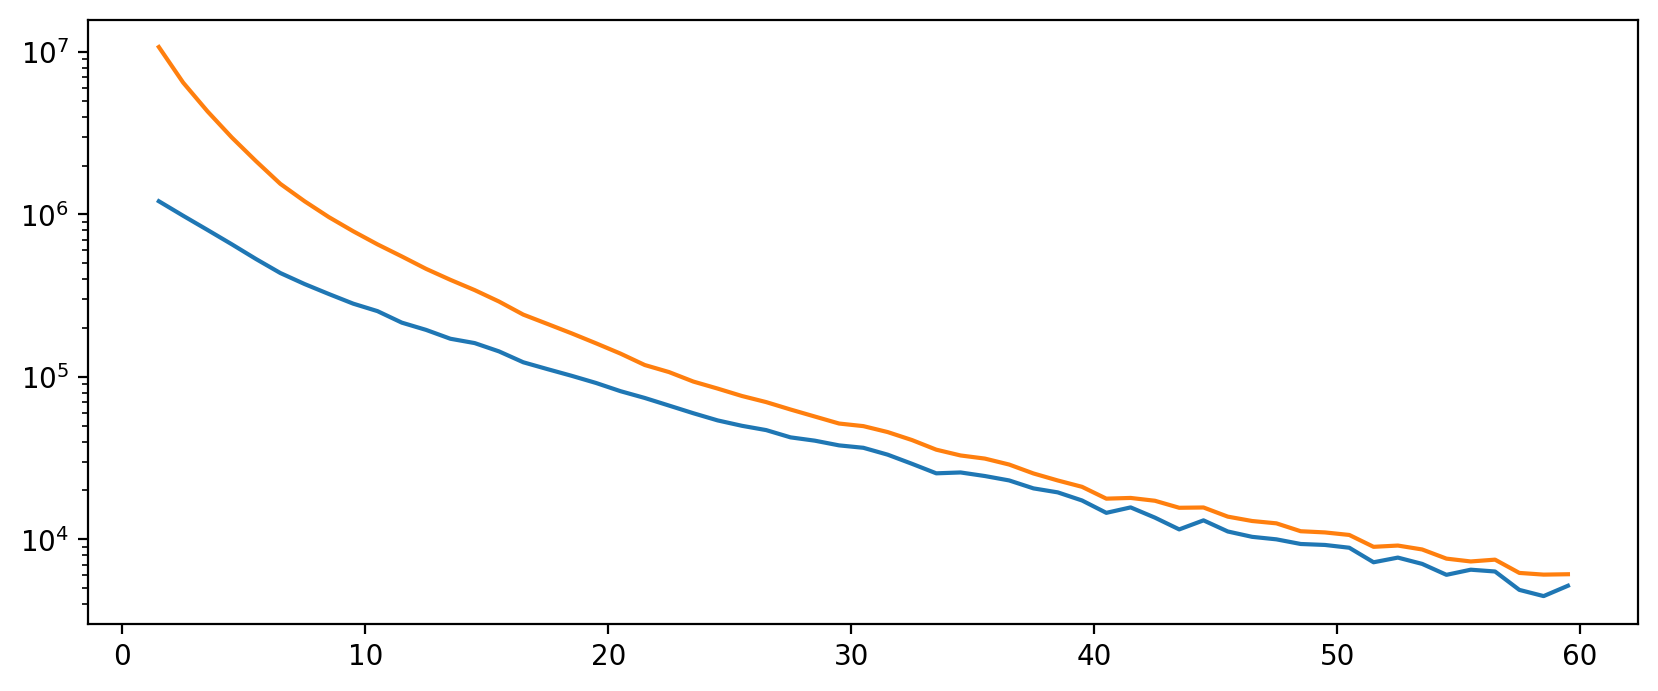

In [13]:
f = plt.figure(figsize=(10,4), dpi=200)
ax = f.add_subplot(111)
ax.set_yscale('log')
plt.plot(outdic['xbins'][posi], outdic['pcount_cores'][posi])
plt.plot(outdic['xbins'][posi], outdic['pcount_GPM'][posi])

In [5]:
perc = np.sum(outdic['pcount_cores'][pos])/np.sum(outdic['pcount_GPM'][pos])

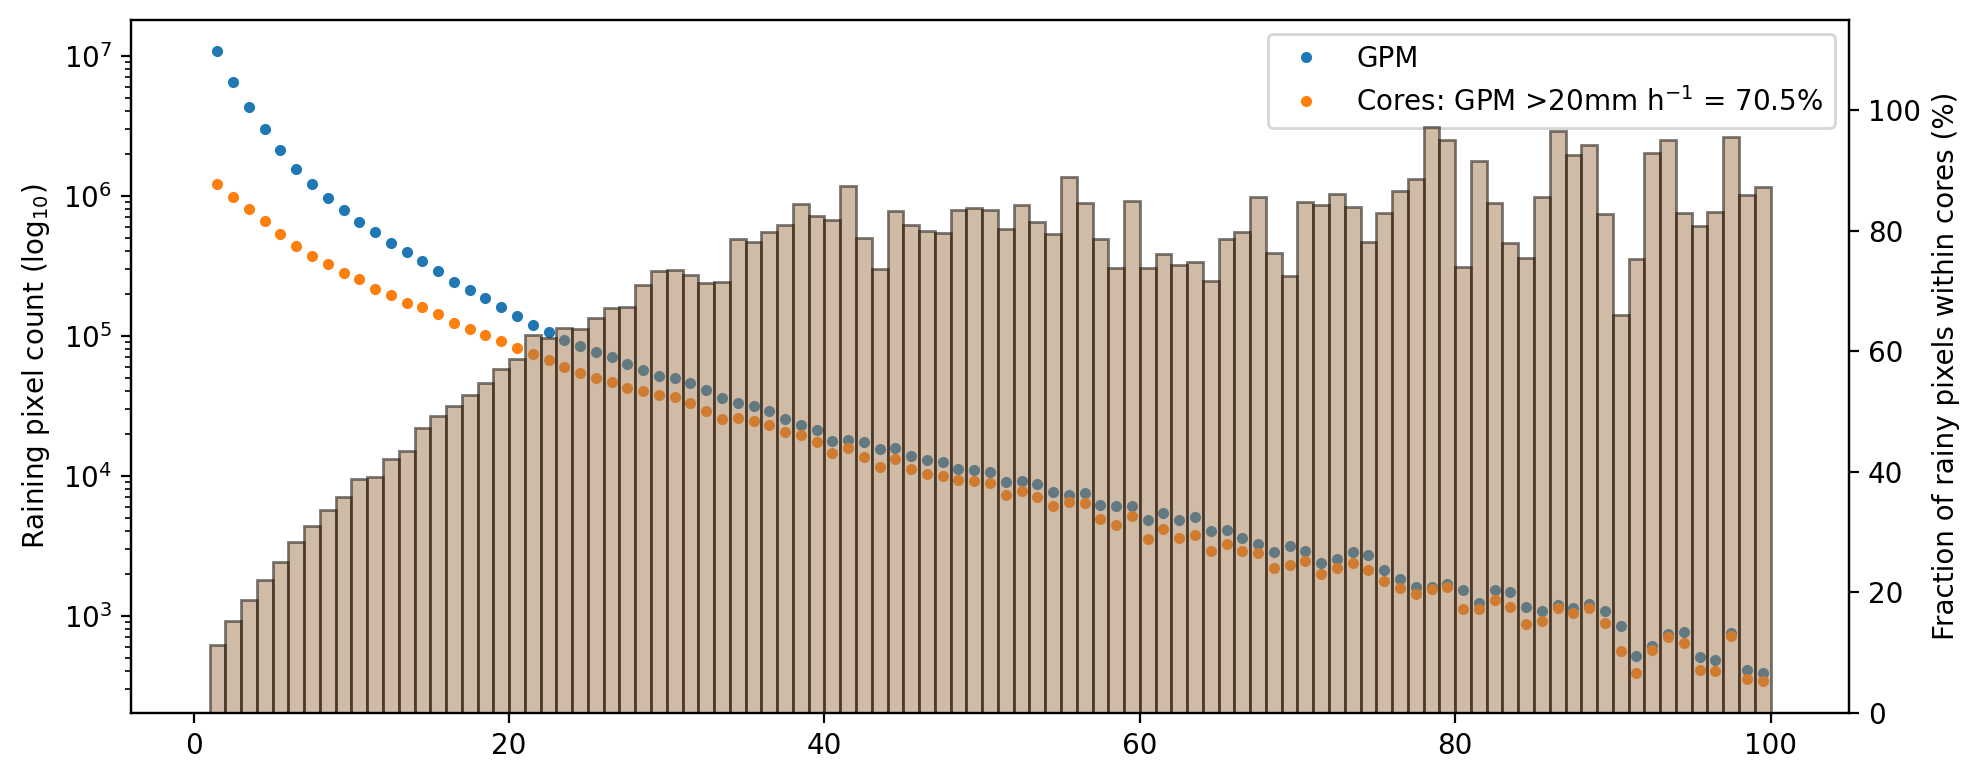

In [6]:
f = plt.figure(figsize=(10,4), dpi=200)
ax = f.add_subplot(111)
ax.set_yscale('log')
ax.plot(outdic['xbins'], outdic['pcount_GPM'], marker='o', label='GPM', zorder=99, ms=3, linestyle='')
ax.plot(outdic['xbins'], outdic['pcount_cores'], marker='o', label='Cores: GPM >20mm h$^{-1}$ = '+str(np.round(perc*100,1))+'%', zorder=99, ms=3, linestyle='')

ax2 = ax.twinx()

ax2.bar(outdic['xbins'], np.array(outdic['cores_frac'])*100, width=1, alpha=0.3, edgecolor='k', zorder=0)
ax2.bar(outdic['xbins'], np.array(outdic['pcount_cores'])/np.array(outdic['pcount_GPM'])*100, width=1, alpha=0.3, edgecolor='k', zorder=0)
ax2.set_ylim(0,115)
ax.legend()
ax.set_ylabel('Raining pixel count (log$_{10}$)')
ax2.set_ylabel('Fraction of rainy pixels within cores (%)')
plt.tight_layout()
#f.savefig("/home/ck/DIR/cornkle/figs/SWIFT/2w_paper/GPM_core_stats.jpg")

In [161]:
outdicold = pd.read_csv("/home/ck/DIR/cornkle/figs/SWIFT/2w_paper/GPM_core_table_old.csv")

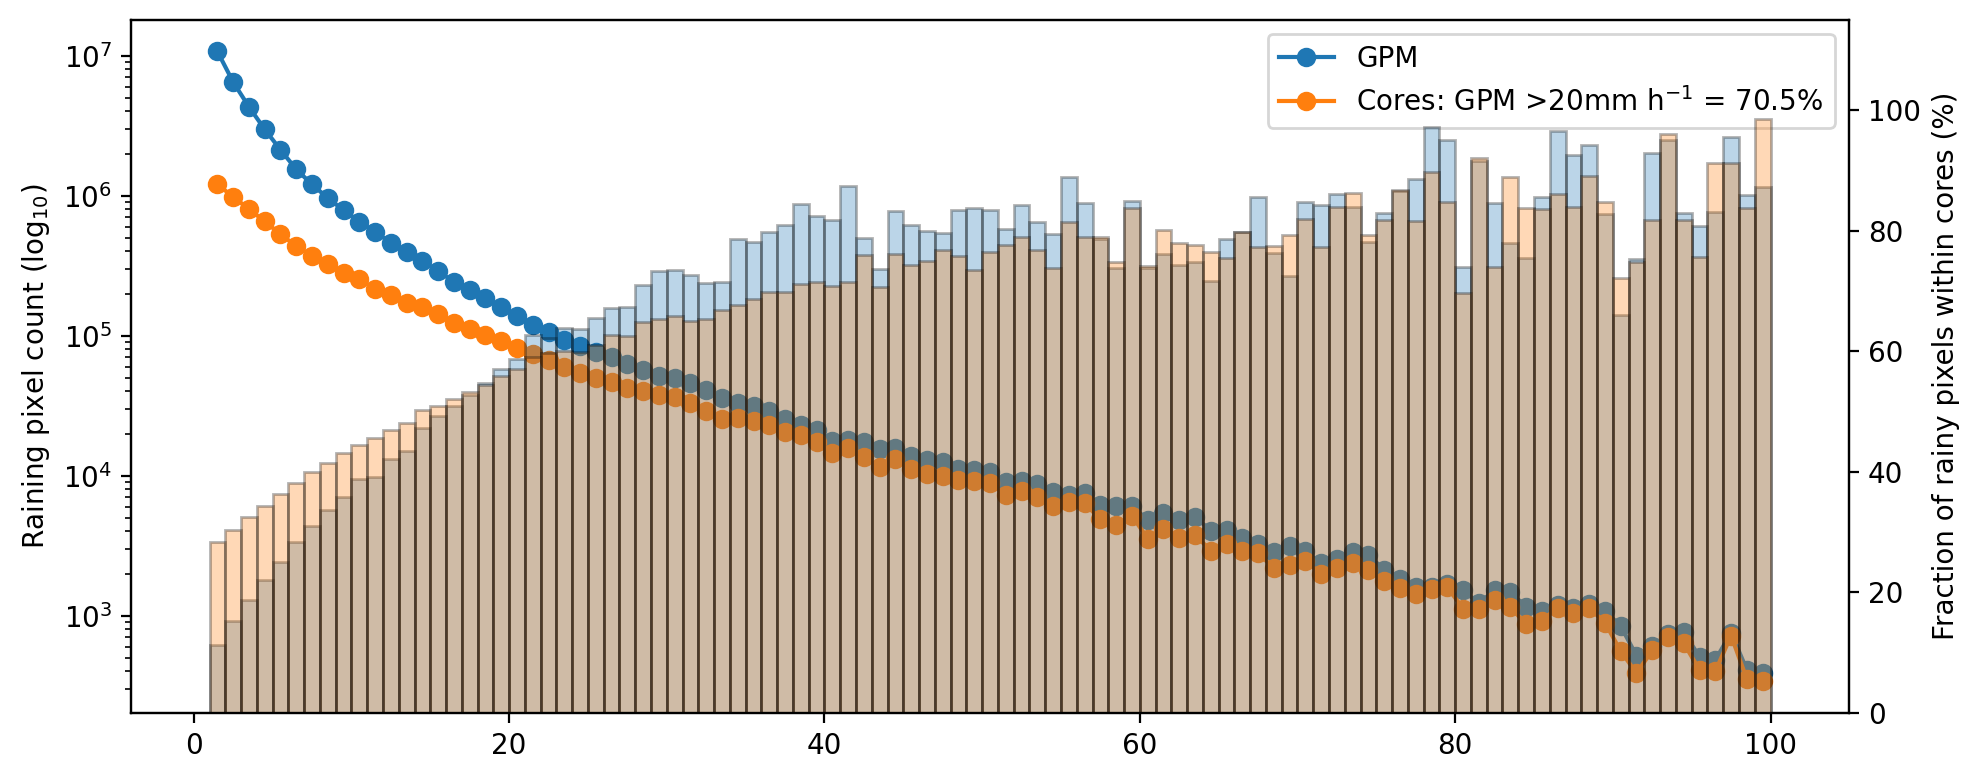

In [162]:
f = plt.figure(figsize=(10,4), dpi=200)
ax = f.add_subplot(111)
ax.set_yscale('log')
ax.plot(outdic['xbins'], outdic['pcount_GPM'], marker='o', label='GPM', zorder=99)
ax.plot(outdic['xbins'], outdic['pcount_cores'], marker='o', label='Cores: GPM >20mm h$^{-1}$ = '+str(np.round(perc*100,1))+'%', zorder=99)

ax2 = ax.twinx()

ax2.bar(outdic['xbins'], np.array(outdic['cores_frac'])*100, width=1, alpha=0.3, edgecolor='k', zorder=0)
ax2.bar(outdicold['xbins'], np.array(outdicold['cores_frac'])*100, width=1, alpha=0.3, edgecolor='k', zorder=0)
ax2.set_ylim(0,115)
ax.legend()
ax.set_ylabel('Raining pixel count (log$_{10}$)')
ax2.set_ylabel('Fraction of rainy pixels within cores (%)')
plt.tight_layout()
#f.savefig("/home/ck/DIR/cornkle/figs/SWIFT/2w_paper/GPM_core_stats.jpg")

In [3]:
outdic = pd.read_csv("/home/ck/DIR/cornkle/figs/SWIFT/2w_paper/GPM_core_table.csv")

In [4]:
pos = outdic['xbins']>=20

In [5]:
perc = np.sum(outdic['pcount_cores'][pos])/np.sum(outdic['pcount_GPM'][pos])

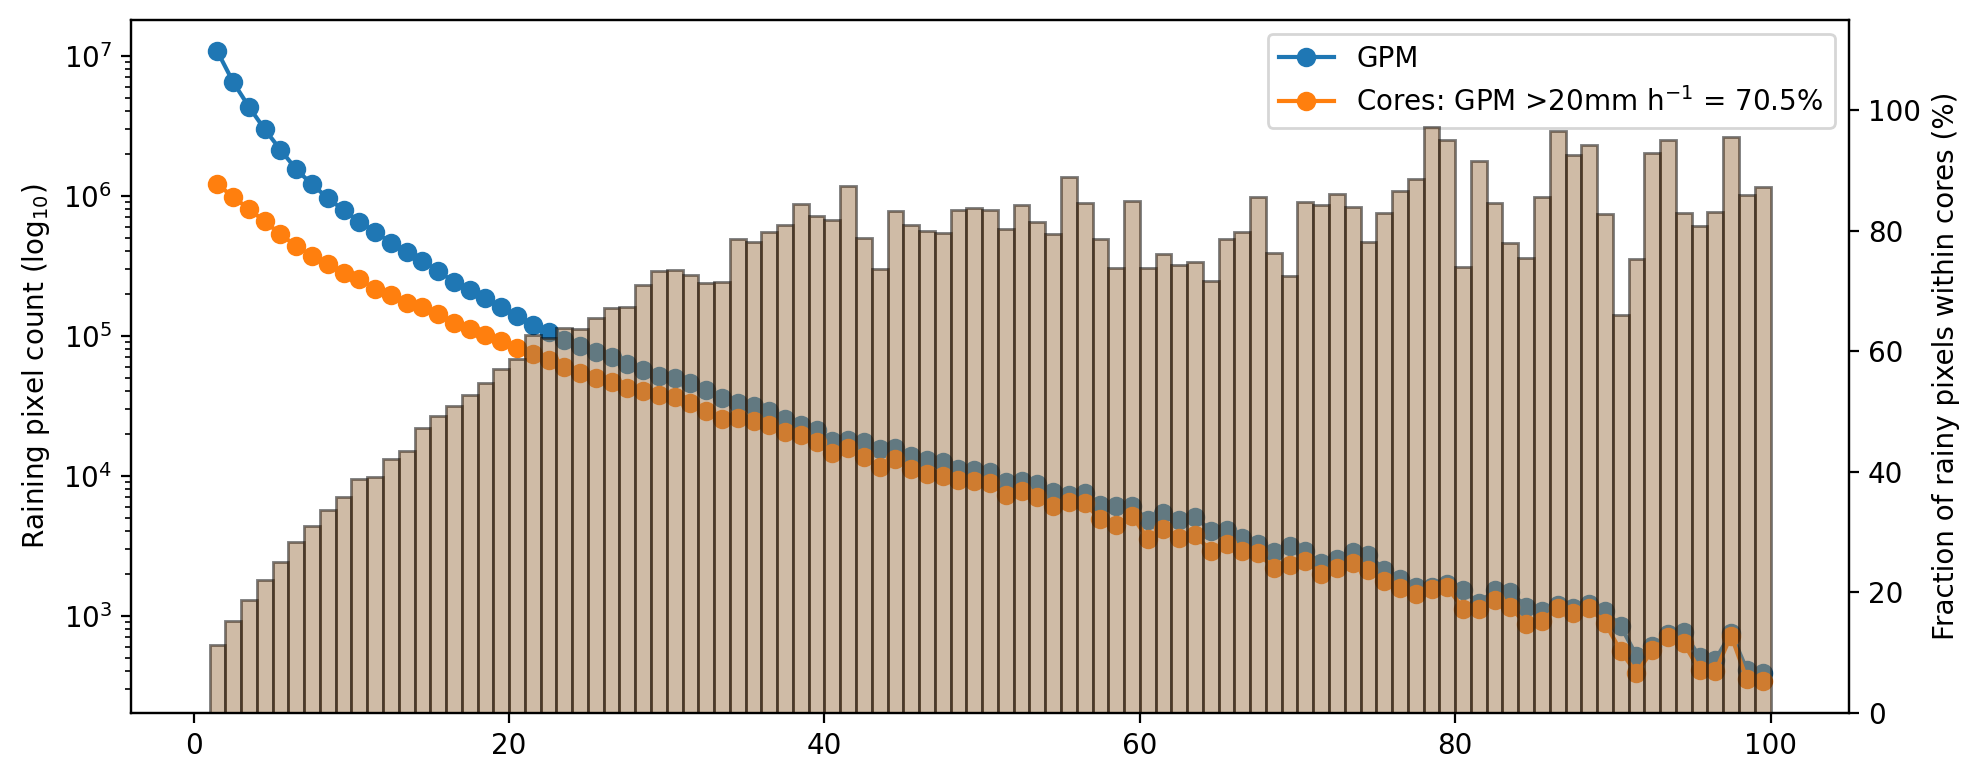

In [6]:
f = plt.figure(figsize=(10,4), dpi=200)
ax = f.add_subplot(111)
ax.set_yscale('log')
ax.plot(outdic['xbins'], outdic['pcount_GPM'], marker='o', label='GPM', zorder=99)
ax.plot(outdic['xbins'], outdic['pcount_cores'], marker='o', label='Cores: GPM >20mm h$^{-1}$ = '+str(np.round(perc*100,1))+'%', zorder=99)

ax2 = ax.twinx()

ax2.bar(outdic['xbins'], np.array(outdic['cores_frac'])*100, width=1, alpha=0.3, edgecolor='k', zorder=0)
ax2.bar(outdic['xbins'], np.array(outdic['pcount_cores'])/np.array(outdic['pcount_GPM'])*100, width=1, alpha=0.3, edgecolor='k', zorder=0)
ax2.set_ylim(0,115)
ax.legend()
ax.set_ylabel('Raining pixel count (log$_{10}$)')
ax2.set_ylabel('Fraction of rainy pixels within cores (%)')
plt.tight_layout()